In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
 
import requests


In [2]:
#getting the file directories for x=features and y=masks

data_dir = '/Users/macbookpro/Desktop/Programmings/Forschungspraktikum/Data/test'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('.png'):
        if not filename.endswith('_seg.png'):
            x.append(os.path.join(data_dir, filename))
        else:
            y.append(os.path.join(data_dir, filename))



In [48]:
# Load x images
x_images = []
for filename in x:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img)
    x_images.append(img_arr)

# Load y images
y_images = []
for filename in y:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img)
    img_arr[img_arr > 1] = 1
    y_images.append(img_arr)
    


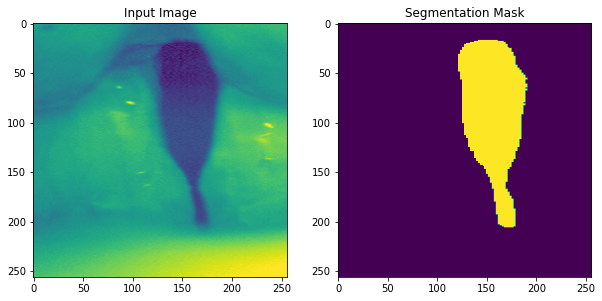

In [49]:
#example plot of x,y

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_images[2])
axs[0].set_title('Input Image')
axs[1].imshow(y_images[2])
axs[1].set_title('Segmentation Mask')
plt.show()

In [57]:
#spliting the data

testno = int(len(x) * (80/100)) 
valno = int(testno + len(x) * (10/100))
trainno = int(valno + len(x) * (10/100))

x_train, y_train = np.array(x_images[:testno]), np.array(y_images[:testno])
x_val, y_val = np.array(x_images[testno:valno]), np.array(y_images[testno:valno])
x_test, y_test = np.array(x_images[valno:trainno]), np.array(y_images[valno:trainno])

# Print number of samples in each set
print('Number of samples in training set:', len(x_train))
print('Number of samples in validation set:', len(x_val))
print('Number of samples in test set:', len(x_test))

Number of samples in training set: 2800
Number of samples in validation set: 350
Number of samples in test set: 350


In [58]:
type(x_train)

numpy.ndarray

In [61]:

inputs = Input((256, 256,1))

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)


#model.summary()




In [39]:
class BotCallback(tf.keras.callbacks.Callback):
    logs_arr = []
    def __init__(self, personal_token=None):
        self.personal_token = '5964545787:AAHRZewVZB1Yqg8qc5Dq1XzzhxfjXFQM_qo'
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result']

    def send_message(self,message):
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)

    def on_epoch_end(self, epoch, logs):
        ac = logs['accuracy']
        loss = logs['loss']
        text = f"*Epoch*: {str(epoch)}\nAccuracy: {str(ac)}\nloss: {str(loss)}."
        self.send_message(text) 
        if epoch == 9:
            self.send_message("*THE END*") 

In [62]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train,validation_data=[x_val, y_val], epochs=10, batch_size=1)

Epoch 1/10
  26/2800 [..............................] - ETA: 2:40:29 - loss: 0.2064 - accuracy: 0.9870

KeyboardInterrupt: 

In [19]:
personal_token = '5964545787:AAHRZewVZB1Yqg8qc5Dq1XzzhxfjXFQM_qo'
ping_url = 'https://api.telegram.org/bot'+str(personal_token)+'/getUpdates'
response = requests.get(ping_url).json()
response

{'ok': True, 'result': []}